## DECOM: INTELIGENCIA COMPUTACIONAL, Prof. Rogério; Marco Túlio S. da Mata; CEFET-MG

## Backpropagation Exercise
In this exercise we will use backpropagation to train a multi-layer perceptron (with a single hidden layer).  We will experiment with different patterns and see how quickly or slowly the weights converge.  We will see the impact and interplay of different parameters such as learning rate, number of iterations, and number of data points.

In [53]:
#Preliminaries
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
%matplotlib inline

Fill out the code below so that it creates a multi-layer perceptron with a single hidden layer (with 4 nodes) and trains it via back-propagation.  Specifically your code should:

1. Initialize the weights to random values between -1 and 1
1. Perform the feed-forward computation
1. Compute the loss function
1. Calculate the gradients for all the weights via back-propagation
1. Update the weight matrices (using a learning_rate parameter)
1. Execute steps 2-5 for a fixed number of iterations
1. Plot the accuracies and log loss and observe how they change over time


Once your code is running, try it for the different patterns below.

- Which patterns was the neural network able to learn quickly and which took longer?
- What learning rates and numbers of iterations worked well?
- If you have time, try varying the size of the hidden layer and experiment with different activation functions (e.g. ReLu)

Shape of x_mat_full is (500, 3)
Shape of circle is (500,)
Shape of diamond is (500,)
Shape of square is (500,)
Shape of thick_angle is (500,)
Shape of thin_angle is (500,)


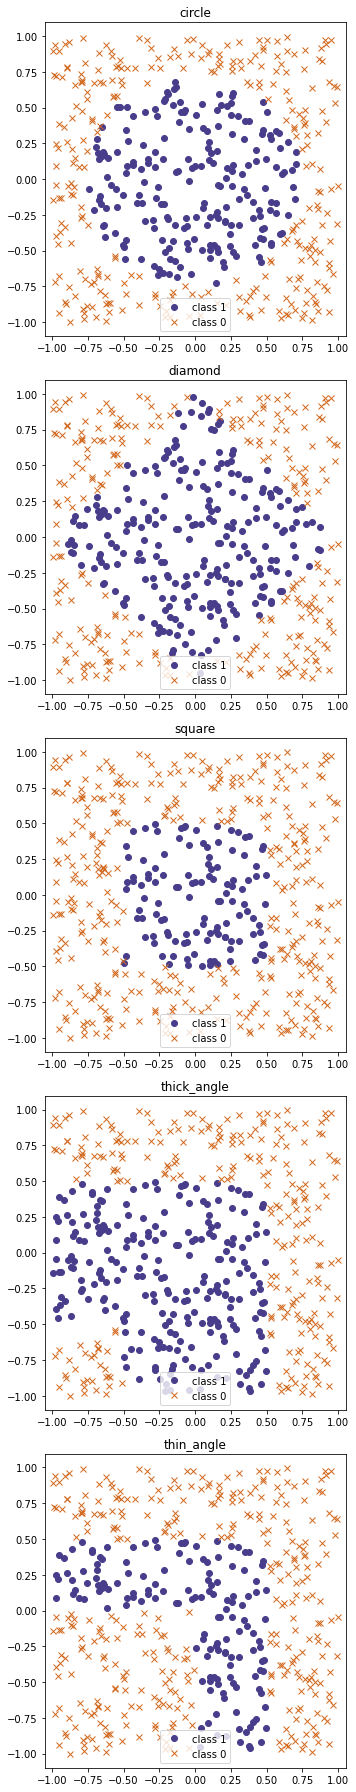

In [54]:
## This code below generates two x values and a y value according to different patterns
## It also creates a "bias" term (a vector of 1s)
## The goal is then to learn the mapping from x to y using a neural network via back-propagation

global x_mat
global y_obj
global num_

num_obs = 500
x_mat_1 = np.random.uniform(-1,1,size = (num_obs,2))
x_mat_bias = np.ones((num_obs,1))
x_mat_full = np.concatenate( (x_mat_1,x_mat_bias), axis=1)

x_mat = x_mat_full

# PICK ONE PATTERN BELOW and comment out the rest.

# # Circle pattern
y_circle = (np.sqrt(x_mat_full[:,0]**2 + x_mat_full[:,1]**2)<.75).astype(int)

# # Diamond Pattern
y_diamond = ((np.abs(x_mat_full[:,0]) + np.abs(x_mat_full[:,1]))<1).astype(int)

# # Centered square
y_square = ((np.maximum(np.abs(x_mat_full[:,0]), np.abs(x_mat_full[:,1])))<.5).astype(int)

# # Thick Right Angle pattern
y_thick_angle = (((np.maximum((x_mat_full[:,0]), (x_mat_full[:,1])))<.5) & ((np.maximum((x_mat_full[:,0]), (x_mat_full[:,1])))>-.5)).astype(int)

# # Thin right angle pattern
y_thin_angle = (((np.maximum((x_mat_full[:,0]), (x_mat_full[:,1])))<.5) & ((np.maximum((x_mat_full[:,0]), (x_mat_full[:,1])))>0)).astype(int)

test_cases = {
    "circle": y_circle,
    "diamond": y_diamond,
    "square": y_square,
    "thick_angle": y_thick_angle,
    "thin_angle": y_thin_angle,
}

print('Shape of x_mat_full is {}'.format(x_mat_full.shape))
for key, value in test_cases.items():
    print(f'Shape of {key} is {value.shape}')

# Plot
fig, axes = plt.subplots(len(test_cases), figsize=(5, 25))
if len(test_cases) == 1:  # Handle case where test_cases has only one entry
    axes = [axes]
    
for (label, y_data), ax in zip(test_cases.items(), axes):
    ax.set_title(label)
    ax.plot(x_mat_full[y_data == 1, 0], x_mat_full[y_data == 1, 1], 'o', label='class 1', color='darkslateblue')
    ax.plot(x_mat_full[y_data == 0, 0], x_mat_full[y_data == 0, 1], 'x', label='class 0', color='chocolate')
    ax.legend(loc='best')
    ax.axis('equal')

plt.tight_layout()
plt.show()

Here are some helper functions

In [55]:
def sigmoid(x):
    """
    Sigmoid function
    """
    return 1.0 / (1.0 + np.exp(-x))


def loss_fn(y_true, y_pred, eps=1e-16):
    """
    Loss function we would like to optimize (minimize)
    We are using Logarithmic Loss
    http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss
    """
    y_pred = np.maximum(y_pred,eps)
    y_pred = np.minimum(y_pred,(1-eps))
    return -(np.sum(y_true * np.log(y_pred)) + np.sum((1-y_true)*np.log(1-y_pred)))/len(y_true)


def forward_pass(W1, W2, y_obj):
    """
    Does a forward computation of the neural network
    Takes the input `x_mat` (global variable) and produces the output `y_pred`
    Also produces the gradient of the log loss function
    """
    # First, compute the new predictions `y_pred`
    z_2 = np.dot(x_mat, W1)
    a_2 = sigmoid(z_2)
    z_3 = np.dot(a_2, W2)
    y_pred = sigmoid(z_3).reshape((len(x_mat),))
    # Now compute the gradient
    J_z_3_grad = -y_obj + y_pred
    J_W_2_grad = np.dot(J_z_3_grad, a_2)
    a_2_z_2_grad = sigmoid(z_2)*(1-sigmoid(z_2))
    J_W_1_grad = (np.dot((J_z_3_grad).reshape(-1,1), W2.reshape(-1,1).T)*a_2_z_2_grad).T.dot(x_mat).T
    gradient = (J_W_1_grad, J_W_2_grad)
    
    # return
    return y_pred, gradient


def plot_loss_accuracy(loss_vals, accuracies, title=None):
    fig = plt.figure(figsize=(16, 8))
    fig.suptitle('Log Loss and Accuracy over iterations -- {}'.format(title), fontsize=16)

    ax = fig.add_subplot(1, 2, 1)
    ax.plot(loss_vals)
    ax.grid(True)
    ax.set(xlabel='iterations', title='Log Loss')

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(accuracies)
    ax.grid(True)
    ax.set(xlabel='iterations', title='Accuracy');

Complete the pseudocode below

In [56]:
#### Initialize the network parameters
def back_propagation(y_label: str, y: list, learning_rates: list, max_ite: int, print_ite_mod: int) -> int:
    np.random.seed(1241)

    W1 = np.random.uniform(-1,1,size = (3,4))
    W2 = np.random.uniform(-1,1,4)
    num_iter = max_ite
    x_mat = x_mat_full
    y_obj = y

    for lr in learning_rates:
        print("Learning rate: {}, Y_Obj: {}".format(lr, y_label))
        loss_vals, accuracies = [], []
        W_1, W_2 = W1.copy(), W2.copy()
        for i in range(num_iter):
            ### Do a forward computation, and get the gradient
            y_pred, gradient = forward_pass(W_1, W_2, y_obj)
            ## Update the weight matrices
            W_1 = W_1 - lr*gradient[0]
            W_2 = W_2 - lr*gradient[1]
            ### Compute the loss and accuracy
            loss_vals.append(loss_fn(y_obj, y_pred,))
            accuracies.append(metrics.accuracy_score(y_obj, np.round(y_pred), normalize=True))
            ## Print the loss and accuracy for every 200th iteration
            if i%print_ite_mod==0:
                print("Iteration: {}, Loss: {}, Accuracy: {}".format(i, loss_vals[-1], accuracies[-1]))
        plot_loss_accuracy(loss_vals, accuracies, title='Learning rate: {}, Y_Obj: {}'.format(lr, y_label))
        
    return 0

Backpropagation[1]: CIRCLE
Learning rate: 0.001, Y_Obj: circle
Iteration: 0, Loss: 0.7346859771551226, Accuracy: 0.576
Iteration: 100, Loss: 0.6777439563545793, Accuracy: 0.576
Iteration: 200, Loss: 0.6751443968919776, Accuracy: 0.576
Iteration: 300, Loss: 0.6704249231606946, Accuracy: 0.576
Iteration: 400, Loss: 0.6611820481887161, Accuracy: 0.526
Iteration: 500, Loss: 0.6434349383396646, Accuracy: 0.562
Iteration: 600, Loss: 0.6137916473449002, Accuracy: 0.642
Iteration: 700, Loss: 0.5764035819835698, Accuracy: 0.728
Iteration: 800, Loss: 0.5437888590654454, Accuracy: 0.736
Iteration: 900, Loss: 0.5210277454242311, Accuracy: 0.734
Learning rate: 0.01, Y_Obj: circle
Iteration: 0, Loss: 0.7346859771551226, Accuracy: 0.576
Iteration: 100, Loss: 0.5023162196934923, Accuracy: 0.754
Iteration: 200, Loss: 0.22289653112383814, Accuracy: 0.938
Iteration: 300, Loss: 0.18271628926078903, Accuracy: 0.944
Iteration: 400, Loss: 0.22800918520758143, Accuracy: 0.882
Iteration: 500, Loss: 0.216071047

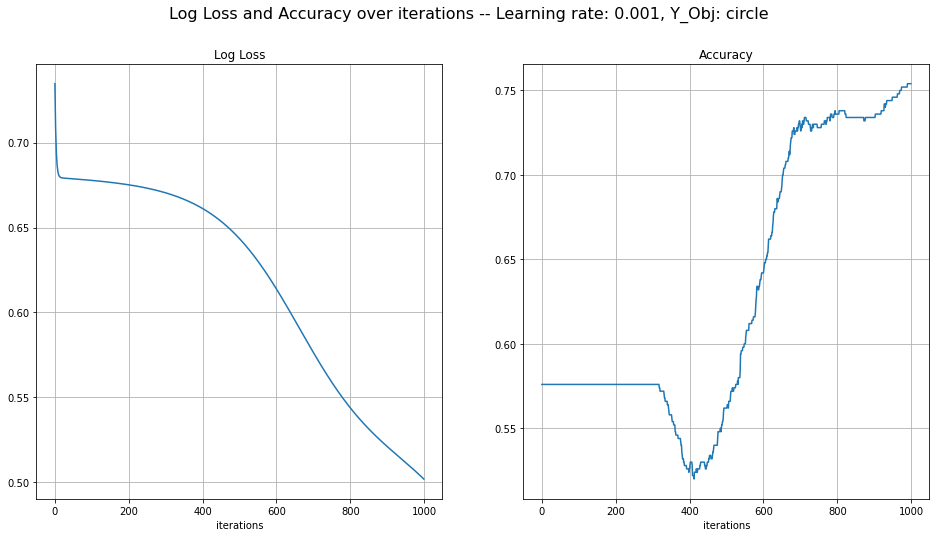

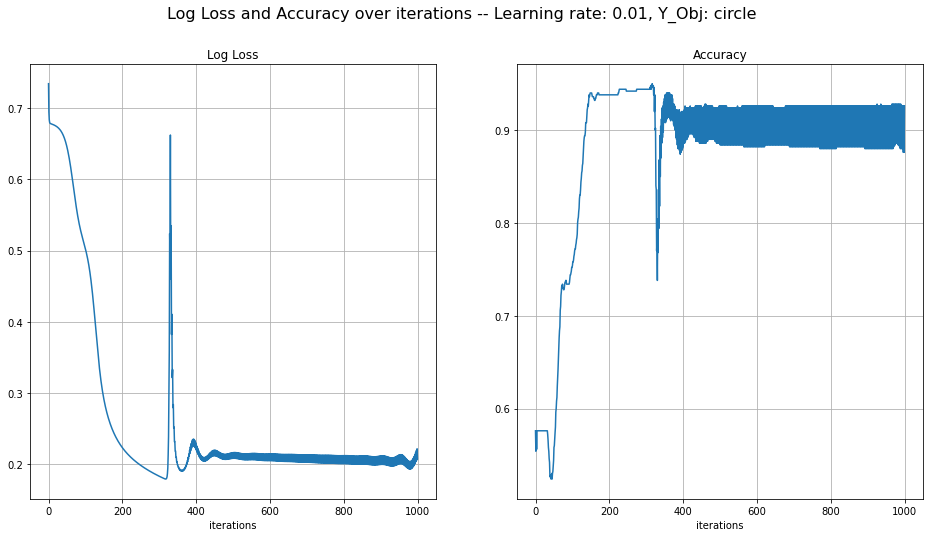

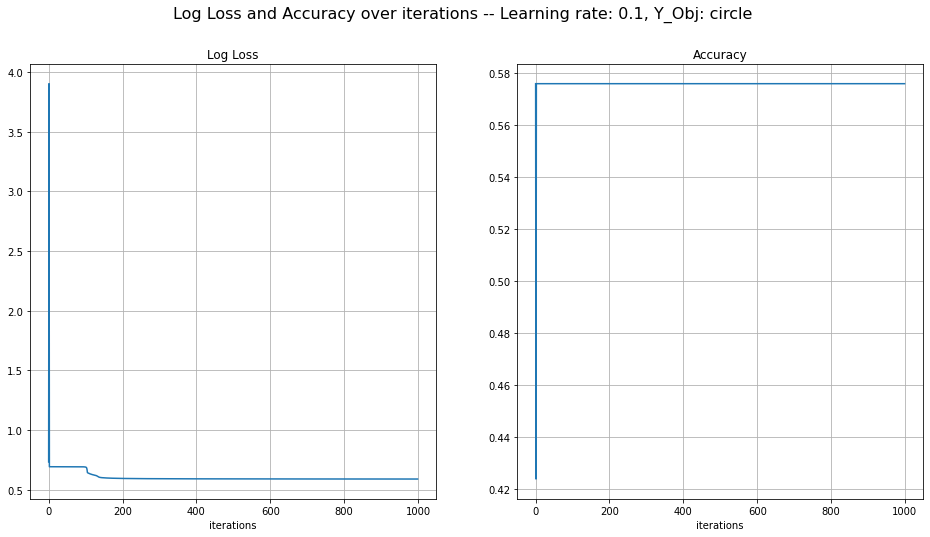

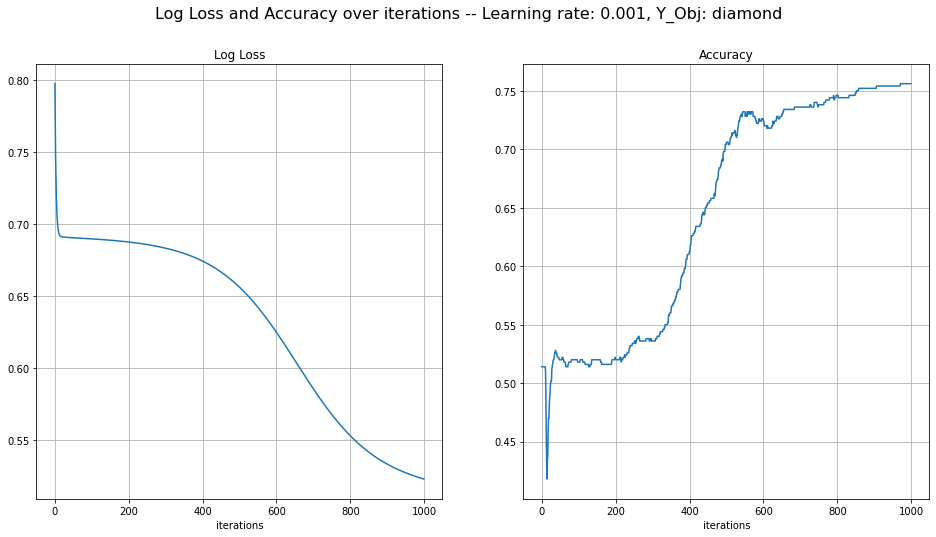

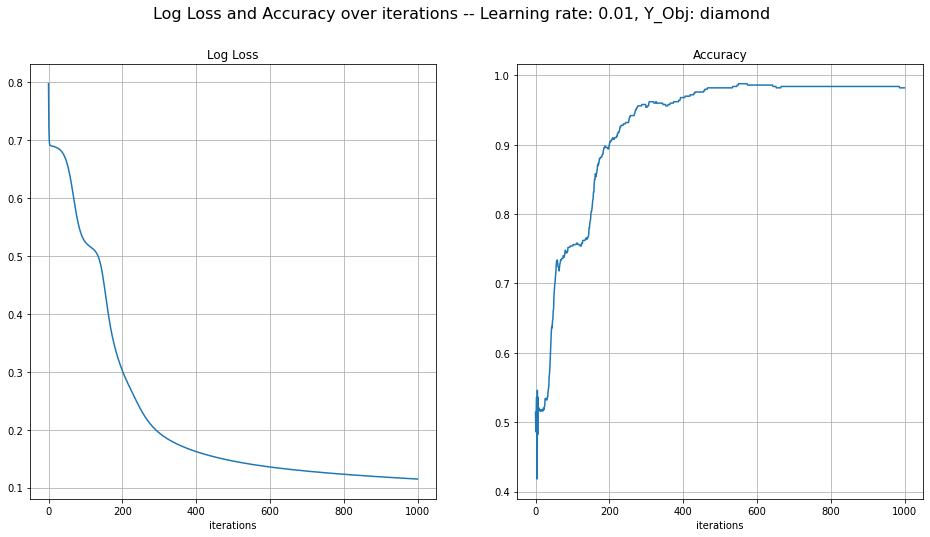

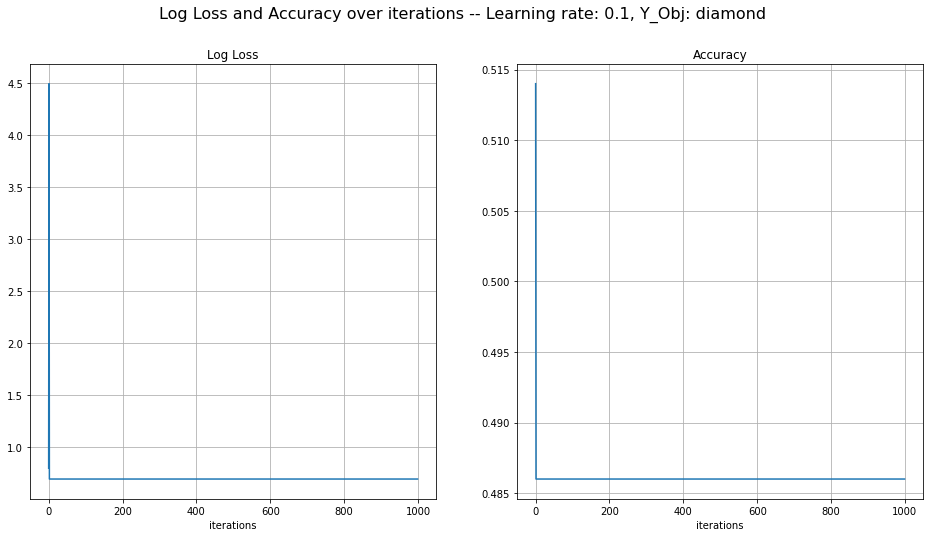

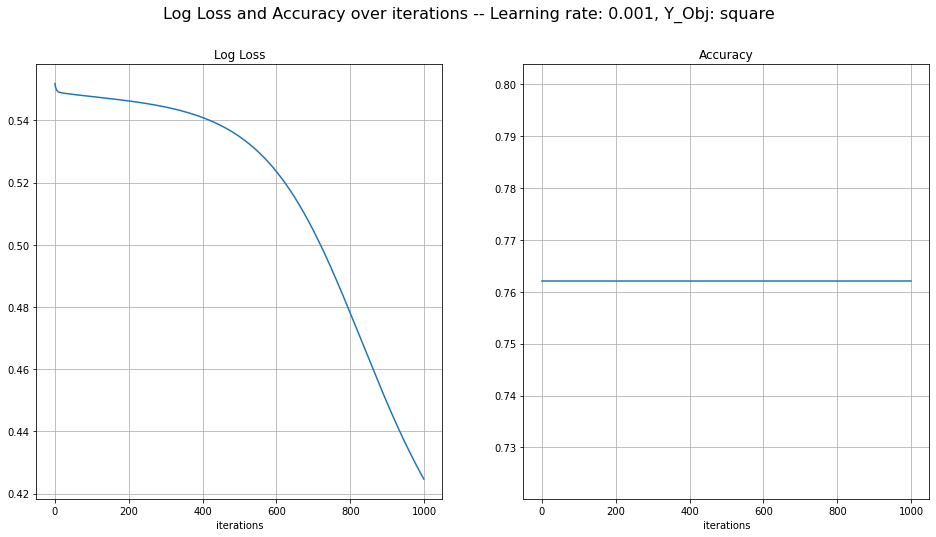

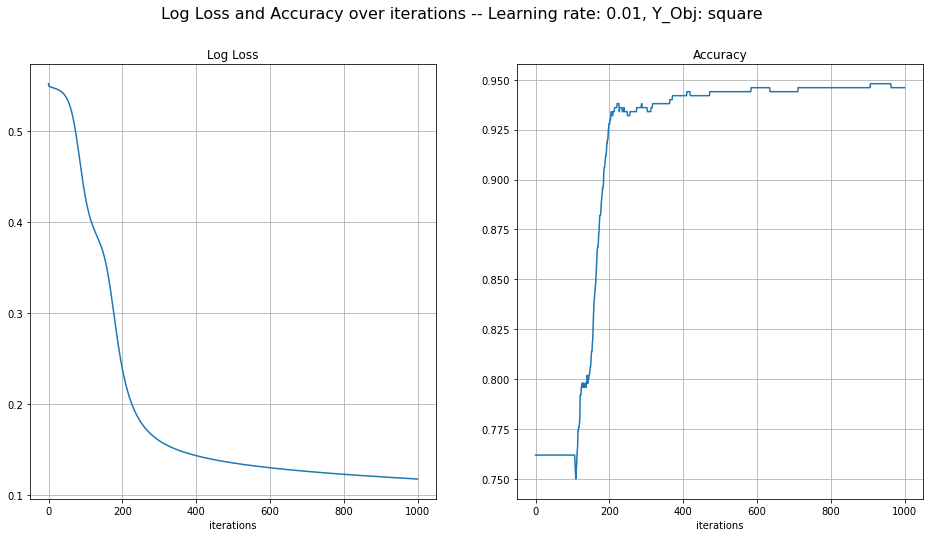

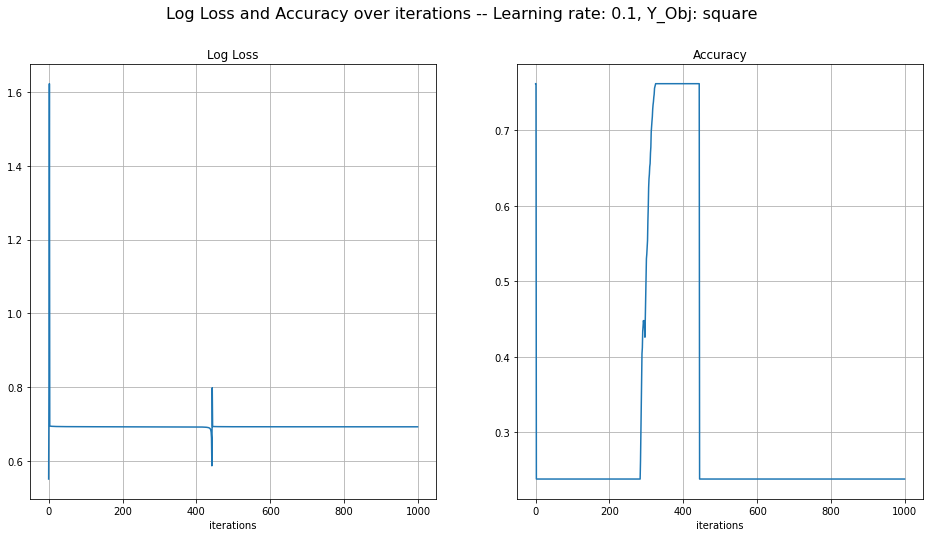

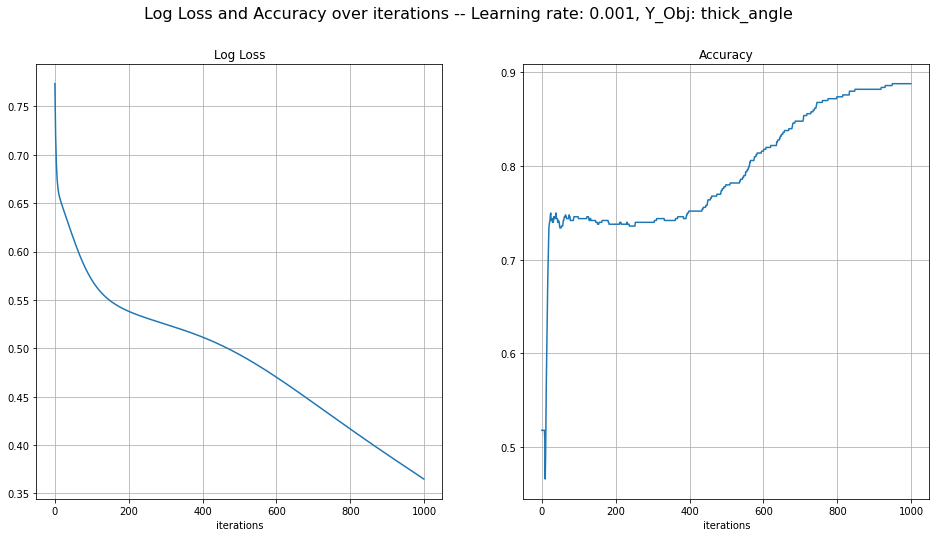

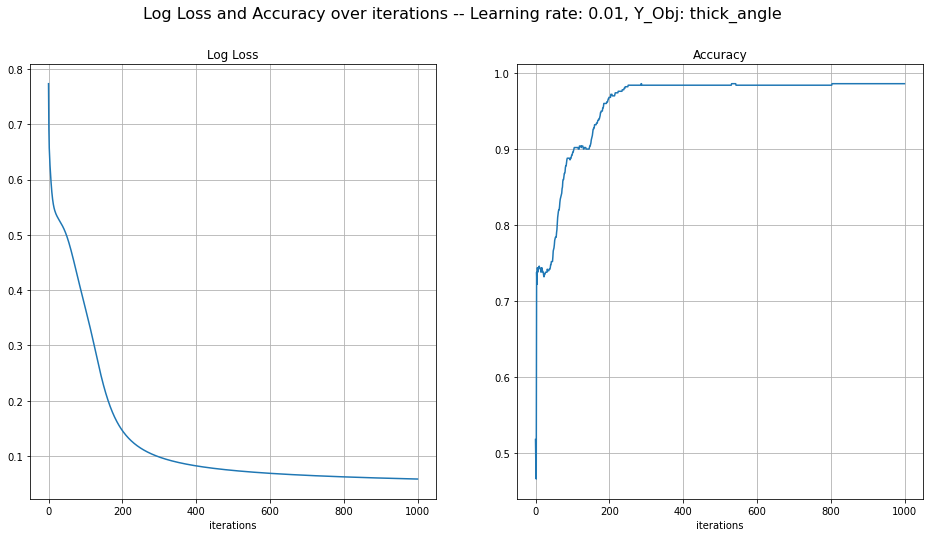

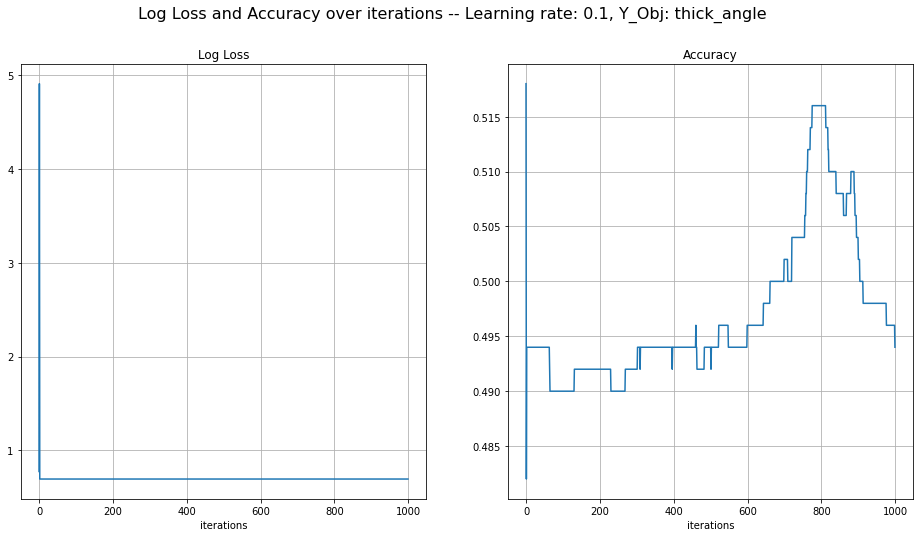

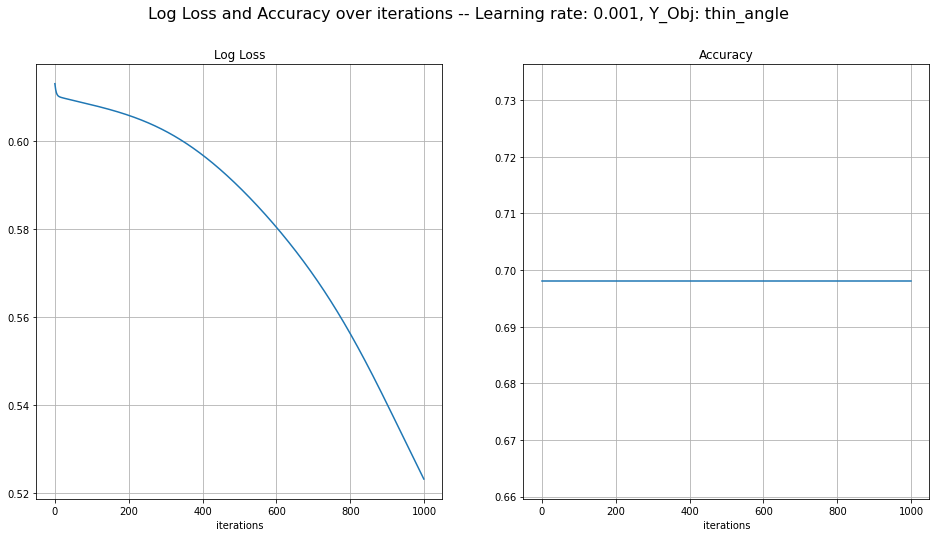

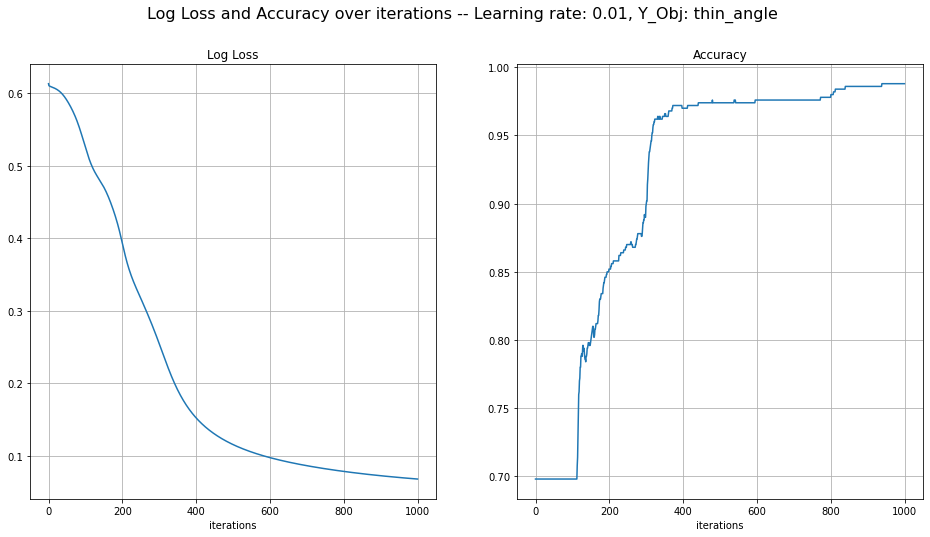

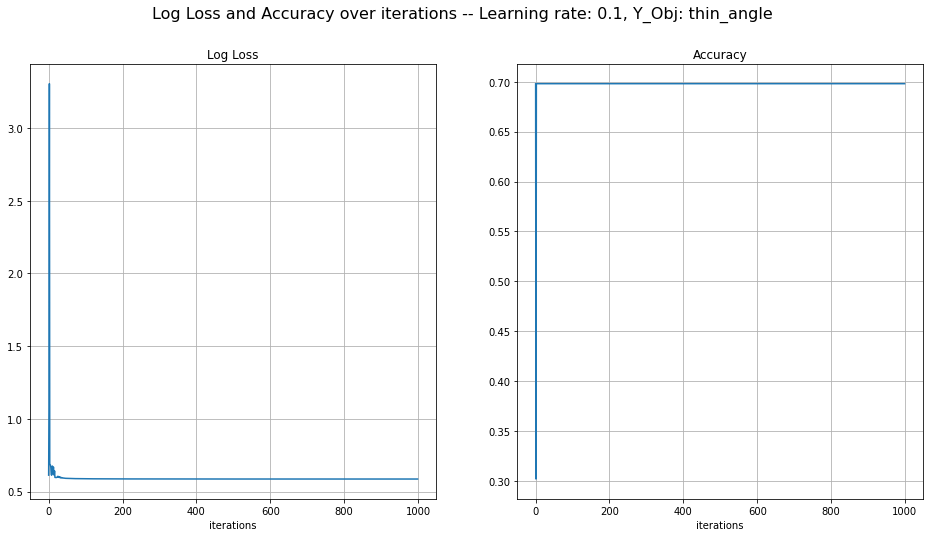

In [57]:
i=1; max_ite=1000; mod_100 = 100
lr=[0.001, 0.01, 0.1]
for key, value in test_cases.items():
	print(f'Backpropagation[{i}]: {key.upper()}' )
	if (back_propagation(y_label=key, y=value, learning_rates=lr, max_ite=max_ite, print_ite_mod=mod_100)):
		break
	i+=1


## *Análise dos Resultados por Taxa de Aprendizado*

**Circle**
No caso do círculo, a taxa de aprendizado que apresentou os melhores resultados foi 0.01, com 1000 iterações. Apesar de ter proporcionado a menor taxa de erro e a maior acurácia, observou-se um ruído significativo tanto no erro quanto na acurácia, o que compromete a precisão dos resultados. Para a taxa 0.001, o erro foi substancialmente mais alto e a acurácia estabilizou em torno de 75%. Esse desempenho indica que, com o aumento do número de iterações, o aprendizado poderia ter melhorado, uma vez que a convergência do modelo é mais lenta. Já para a taxa de aprendizado 0.1, o modelo apresentou um erro extremamente elevado e uma acurácia muito baixa, com uma convergência abrupta logo nas primeiras iterações, o que resultou em um desempenho insatisfatório.

**Diamond**
Assim como no círculo, a taxa de aprendizado que proporcionou os melhores resultados foi 0.01. Com ela, o modelo apresentou um erro baixo e uma acurácia elevada, demonstrando que a rede conseguiu aprender de forma eficiente. Na taxa 0.001, o erro foi muito alto e a acurácia bastante baixa, evidenciando que o modelo não foi capaz de aprender adequadamente com o número de iterações utilizadas, dado o ritmo lento de convergência. Por outro lado, a taxa 0.1 resultou novamente em um desempenho insatisfatório, com um erro elevado e uma acurácia muito baixa, além de uma convergência abrupta nas primeiras iterações.

**Square**
Para o quadrado, a taxa 0.01 também se destacou como a melhor. O modelo apresentou um erro baixo e uma acurácia elevada, indicando que o aprendizado ocorreu de maneira eficaz. Por outro lado, para a taxa 0.001, o erro foi alto e a acurácia permaneceu praticamente constante, o que sugere que o modelo não conseguiu aprender de forma satisfatória. Já para a taxa 0.1, os resultados foram similares aos obtidos para os outros casos: erro elevado, acurácia muito baixa, convergência abrupta no início do treinamento e divergências significativas conforme o número de iterações aumentava.

**Thick Angle**
Neste caso, as taxas 0.01 e 0.001 apresentaram resultados próximos, embora a 0.01 tenha se sobressaído devido ao aprendizado mais rápido, menor erro e maior acurácia. Para a taxa 0.001, observou-se uma tendência de redução do erro com o aumento do número de iterações, enquanto a acurácia já apresentava valores relativamente altos. Para a taxa 0.1, o erro teve um decaimento extremamente abrupto, mas permaneceu elevado, além de uma clara divergência nos resultados de acurácia, evidenciando o baixo desempenho.

**Thin Angle**
A taxa 0.01 foi, mais uma vez, a que apresentou o melhor desempenho, com o menor erro e a maior acurácia. Na taxa 0.001, o erro foi elevado e a acurácia permaneceu constante, indicando que o modelo não funcionou adequadamente nesse caso. Por fim, a taxa 0.1 apresentou os piores resultados, com erro alto, acurácia baixa e uma convergência abrupta nas primeiras iterações.

### *Conclusão*

* Melhor Taxa de Aprendizado: Em todos os casos analisados, a taxa 0.01 foi a que proporcionou os melhores resultados, apresentando um bom equilíbrio entre erro e acurácia. Portanto, pode-se concluir que esta é a taxa de aprendizado mais adequada para os dados utilizados neste experimento.

* Pior Taxa de Aprendizado: A taxa 0.1 consistentemente apresentou os piores resultados, caracterizados por erros elevados, baixa acurácia e convergência precoce e abrupta. Assim, essa taxa deve ser evitada.

* Taxa de Aprendizado Intermediária: Embora a taxa 0.001 tenha apresentado resultados inferiores à taxa 0.01, é importante ressaltar que seu desempenho poderia ser melhorado com o aumento do número de iterações, devido ao seu comportamento de convergência mais lenta.